## Preamble

Run code in this section first. All other sections are independent from each other, and cells within each section have to be ran sequentially.

In [1]:
using DrWatson
@quickactivate "Data-driven resolvent"

include(srcdir("GinzburgLandau.jl"))
using Plots, Plots.PlotMeasures, LaTeXStrings
using LinearAlgebra,Statistics

Build the linearized Ginzburg-Landau operator

In [2]:
A,Q,x,p = gl_subcritical_setup();

Load dataset and assemble snapshot matrices

In [3]:
data = wload(datadir("sims","ginzburg_landau","data.bson"))
@unpack t,x,q = data
m = length(t)
dt = t[2]
F = factorize_weights(Q)
Fi = F\I
n_runs = 30
X = hcat([F*(q[i][:,1:m-1]) for i=1:n_runs]...)
Y = hcat([F*(q[i][:,2:m]) for i=1:n_runs]...);

## Resolvent gains

Compute operator-based gain distribution

In [4]:
ωspan = collect(-3:0.05:3.0)
@time R = opt_gain(A,Q,ωspan,4);

  4.043365 seconds (10.45 M allocations: 972.256 MiB, 9.12% gc time)


Compute data-driven gain distribution

In [5]:
λ̃,Ṽ,W̃,b = DMD(X,Y,dt,50,1e-16)
Ṽ = Fi*Ṽ
W̃ = Fi*W̃
r = 24
@time R̃ = opt_gain(λ̃[1:r],Ṽ[:,1:r],Q,ωspan,4);

  0.304164 seconds (1.16 M allocations: 65.314 MiB, 7.70% gc time)


Plot and save gain distribution comparison

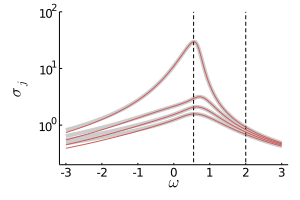

In [6]:
plot(ωspan,sqrt.(R'),yscale=:log10,size=(300,200),leg=false,lc=:gray80,lw=4,
    ylim=(2e-1,1e2),yticks=[1,10,100],grid=false,xlabel=L"\omega",ylabel=L"\sigma_j")
plot!([0.55,0.55],[0.1,100],ls=:dash,c=:black)
plot!([2,2],[0.1,100],ls=:dash,c=:black)
display(plot!(ωspan,sqrt.(R̃'),c=:indianred,lw=1))
# savefig(plotsdir("gl_gain_marked.pdf"))

## Resolvent modes

### $\omega=0.55$

Compute operator-based resolvent modes

In [7]:
ω = 0.55
Ψ,σ,Φ = opt_forcing(A,Q,ω);

Compute data-driven resolvent modes

In [13]:
λ̃,Ṽ,W̃,b = DMD(X,Y,dt,50,1e-16)
Ṽ = Fi*Ṽ
W̃ = Fi*W̃
r = 24
Ψ̃,σ̃,Φ̃ = opt_forcing(λ̃[1:r],Ṽ[:,1:r],Q,ω);

Phase align data-driven and operator-based modes

In [14]:
for j=1:4
χ = (Ψ̃[:,j]\Ψ[:,j])
Φ̃[:,j] = Φ̃[:,j]*χ
Ψ̃[:,j] = Ψ̃[:,j]*χ
end

Plot and save mode comparison

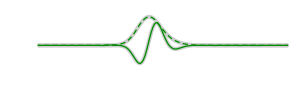

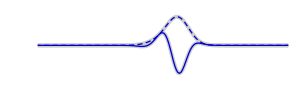

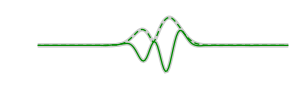

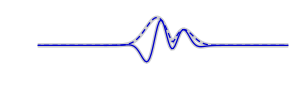

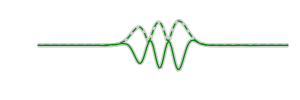

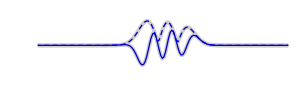

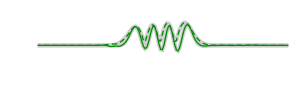

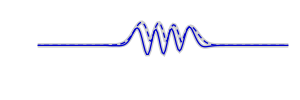

In [72]:
gr(leg=false,grid=false)
lw=1.3

for j=1:4
    
# forcing modes phi_j

plot(x,abs.(Φ[:,j]),size=(300,100),xlim=(-50,50),ylim=(-0.4,0.4),
    yaxis=false,xaxis=false,lc=:gray80,lw=4)
plot!(x,real.(Φ[:,j]),lc=:gray80,lw=4)
plot!(x,abs.(Φ̃[:,j]),lc=:green4,lw=lw,ls=:dash)
display(plot!(x,real.(Φ̃[:,j]),lc=:green4,lw=lw))
savefig(plotsdir("gl_forcing_mode_w=055_$(j).pdf"))
    
# response psi_j
    
plot(x,abs.(Ψ[:,j]),size=(300,100),xlim=(-50,50),ylim=(-0.4,0.4),
    yaxis=false,xaxis=false,lc=:gray80,lw=4)
plot!(x,real.(Ψ[:,j]),lc=:gray80,lw=4)
plot!(x,abs.(Ψ̃[:,j]),lc=:blue3,lw=lw,ls=:dash)
display(plot!(x,real.(Ψ̃[:,j]),lc=:blue3,lw=lw))
savefig(plotsdir("gl_response_mode_w=055_$(j).pdf"))
    
end

Convergence with number of transients in the dataset

In [41]:
eϕ = zeros(4,30)
eψ = zeros(4,30)
for p=1:30
    λ̃,Ṽ,W̃,b = DMD(X[:,1:(m-1)*p],Y[:,1:(m-1)*p],dt,r,1e-16)
    Ṽ = Fi*Ṽ
    W̃ = Fi*W̃
    Ψ̃,σ̃,Φ̃ = opt_forcing(λ̃[1:r],Ṽ[:,1:r],Q,ω)
    for j=1:4
        χ = (Ψ̃[:,j]\Ψ[:,j])
        Φ̃[:,j] = Φ̃[:,j]*χ
        Ψ̃[:,j] = Ψ̃[:,j]*χ
        dϕ = Φ[:,j]-Φ̃[:,j]
        dψ = Ψ[:,j]-Ψ̃[:,j]
        eϕ[j,p] = sqrt.(real(dϕ'*Q*dϕ))
        eψ[j,p] = sqrt.(real(dψ'*Q*dψ))
    end
end

Plot and save results

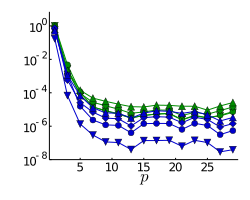

In [42]:
ps = collect(1:2:30)
plot(ps,eϕ[:,1:2:end]',size=(250,200),c=:green4,leg=false,marker=3.5,
    markershape=[:dtriangle :circle :diamond :utriangle],ylim=(1e-8,7),
    grid=false,xlabel=L"p",yscale=:log10)

display(plot!(ps,eψ[:,1:2:end]',marker=3.5,markershape=[:dtriangle :circle :diamond :utriangle], c=:blue3))

# savefig(plotsdir("gl_error_w=055.pdf"))

### $\omega=2.0$

Compute operator-based resolvent modes

In [73]:
ω = 2
Ψ,σ,Φ = opt_forcing(A,Q,ω);

Compute data-driven resolvent modes

In [74]:
λ̃,Ṽ,W̃,b = DMD(X,Y,dt,50,1e-16)
Ṽ = Fi*Ṽ
W̃ = Fi*W̃
r = 24
Ψ̃,σ̃,Φ̃ = opt_forcing(λ̃[1:r],Ṽ[:,1:r],Q,ω);

Phase align data-driven and operator-based modes

In [75]:
for j=1:4
χ = (Ψ̃[:,j]\Ψ[:,j])
Φ̃[:,j] = Φ̃[:,j]*χ
Ψ̃[:,j] = Ψ̃[:,j]*χ
end

Plot and save mode comparison

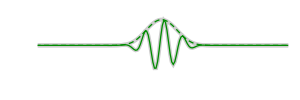

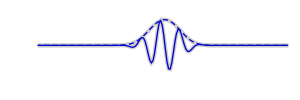

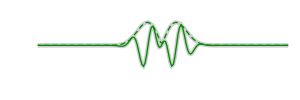

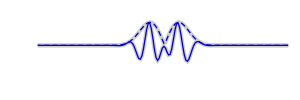

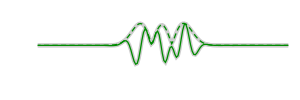

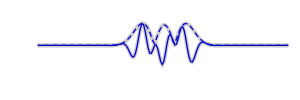

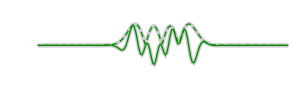

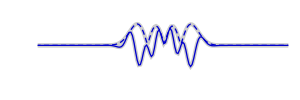

In [79]:
gr(leg=false,grid=false)
lw=1.3

for j=1:4
    
# forcing modes phi_j

plot(x,abs.(Φ[:,j]),size=(300,100),xlim=(-50,50),ylim=(-0.4,0.4),
    yaxis=false,xaxis=false,lc=:gray80,lw=4)
plot!(x,real.(Φ[:,j]),lc=:gray80,lw=4)
plot!(x,abs.(Φ̃[:,j]),lc=:green4,lw=lw,ls=:dash)
display(plot!(x,real.(Φ̃[:,j]),lc=:green4,lw=lw))
savefig(plotsdir("gl_forcing_mode_w=2_$(j).pdf"))
    
# response psi_j
    
plot(x,abs.(Ψ[:,j]),size=(300,100),xlim=(-50,50),ylim=(-0.4,0.4),
    yaxis=false,xaxis=false,lc=:gray80,lw=4)
plot!(x,real.(Ψ[:,j]),lc=:gray80,lw=4)
plot!(x,abs.(Ψ̃[:,j]),lc=:blue3,lw=lw,ls=:dash)
display(plot!(x,real.(Ψ̃[:,j]),lc=:blue3,lw=lw))
savefig(plotsdir("gl_response_mode_w=2_$(j).pdf"))
    
end

Convergence with number of transients in the dataset

In [63]:
eϕ = zeros(4,30)
eψ = zeros(4,30)
for p=1:30
    λ̃,Ṽ,W̃,b = DMD(X[:,1:(m-1)*p],Y[:,1:(m-1)*p],dt,r,1e-16)
    Ṽ = Fi*Ṽ
    W̃ = Fi*W̃
    Ψ̃,σ̃,Φ̃ = opt_forcing(λ̃[1:r],Ṽ[:,1:r],Q,ω)
    for j=1:4
        χ = (Ψ̃[:,j]\Ψ[:,j])
        Φ̃[:,j] = Φ̃[:,j]*χ
        Ψ̃[:,j] = Ψ̃[:,j]*χ
        dϕ = Φ[:,j]-Φ̃[:,j]
        dψ = Ψ[:,j]-Ψ̃[:,j]
        eϕ[j,p] = sqrt.(real(dϕ'*Q*dϕ))
        eψ[j,p] = sqrt.(real(dψ'*Q*dψ))
    end
end

Plot and save results

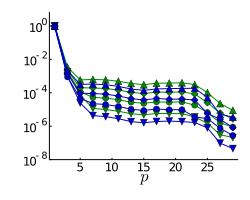

In [64]:
ps = collect(1:2:30)
plot(ps,eϕ[:,1:2:end]',size=(250,200),c=:green4,leg=false,marker=3.5,
    markershape=[:dtriangle :circle :diamond :utriangle],ylim=(1e-8,7),
    grid=false,xlabel=L"p",yscale=:log10)

display(plot!(ps,eψ[:,1:2:end]',marker=3.5,markershape=[:dtriangle :circle :diamond :utriangle], c=:blue3))

savefig(plotsdir("gl_error_w=2.pdf"))

## Generate dataset

Run simulations and save transients

In [ ]:
n_sims = 30
A,Q,x,p = gl_subcritical_setup()
@time t,x,q = gl_run_transient(n_sims)
data = @dict(t,x,q)
wsave(datadir("sims","ginzburg_landau","data.bson"),data)

Plot and save data

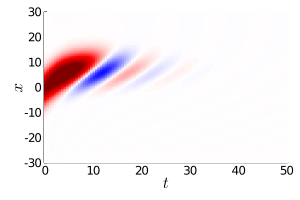

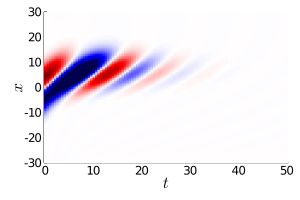

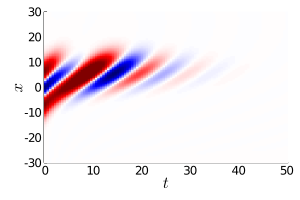

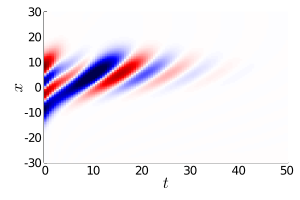

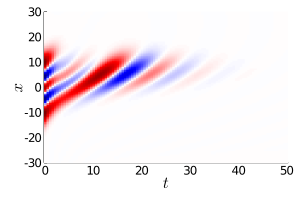

In [65]:
data = wload(datadir("sims","ginzburg_landau","data.bson"))
@unpack t,x,q = data
for i=1:5
    lim = 1*maximum(abs.(q[i][:,1]))
    display(heatmap(t,x,real.(q[i]),ylim=(-30,30),c=:seismic,
            xlabel=L"t",ylabel=L"x",clim=(-lim,lim),size=(300,200)))
#     savefig(plotsdir("ginzburg_landau","transient_$i.pdf"))
end